# Blackjack - prediction

In this notebook, we are interested in *learning* the value-function $v_\pi(s)$ and action-value function $q_\pi(s, a)$ for a given policy $\pi$

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numba import njit
from numba.core import types
from numba.typed import Dict

In [2]:
%config InlineBackend.figure_format = "retina"
np.set_printoptions(suppress=True)

* **Stick**: Player stops
* **Hit**: Request an additional card

In [3]:
# Value 10 corresponds to 10, Jack, Queen, and King.
n_vals = np.ones(10)
n_vals[-1] = 4
deck_probs = n_vals / n_vals.sum()

In [17]:
value = 21
value - PLAY_MINVAL

19

In [18]:
CARD_MIN = 1
CARD_MAX = 10

In [359]:
@njit
def set_seed(value):
    """
    See: https://github.com/numba/numba/issues/6002
    """
    np.random.seed(value)
    

@njit
def draw_card():
    return np.random.multinomial(1, deck_probs).argmax() + 1


@njit
def compute_reward(value_cards_player, value_cards_dealer):
    if value_cards_player == value_cards_dealer == 21:
        reward = 0 # draw
    elif value_cards_player > 21:
        reward = -1 # lose
    elif value_cards_dealer > 21:
        reward = 1 # win
    elif value_cards_player == value_cards_dealer:
        reward = 0 # draw
    elif value_cards_player > value_cards_dealer:
        reward = 1 # win
    else:
        reward = -1 # lose
    
    return reward


@njit
def init_game():
    value_cards_player = np.array([draw_card(), draw_card()])
    has_usable_ace = 1 in value_cards_player
    value_cards_player = value_cards_player.sum() + 10 * has_usable_ace
    
    dealers_card = draw_card() # Dealer's one-showing card
    
    return value_cards_player, has_usable_ace, dealers_card


@njit
def update_hand(value_cards):
    """
    Update the value of the hand for either the player
    or the dealer
    """
    new_card = draw_card()
    value_cards = value_cards + new_card
    
    if (new_card == 1) and (value_cards <= 10):
        has_usable_ace = True
        value_cards = value_cards + 10 # Make use of the ace
        
    return value_cards, has_usable_ace


@njit
def state_to_ix(value_cards_player, has_usable_ace, dealers_card):
    ix_value_cards = value_cards_player - PLAY_MINVAL
    ix_has_usable_ace = int(has_usable_ace)
    ix_dealers_card = dealers_card - CARD_MIN
    
    ixs = ix_value_cards, ix_has_usable_ace, ix_dealers_card
    return ixs


@njit
def step_player(
    value_cards_player,
    has_usable_ace,
    dealers_card,
    policy
):
    continue_play = True
    # turn into indices
    ixs = state_to_ix(value_cards_player, has_usable_ace, dealers_card)
    ix_value_cards, ix_has_usable_ace, ix_dealers_card = ixs
    action = policy[ix_value_cards, ix_has_usable_ace, ix_dealers_card]
    
    if action == 1:
        value_cards_player, has_usable_ace_new = update_hand(value_cards_player)
        has_usable_ace = has_usable_ace or has_usable_ace_new
        
    if (value_cards_player >= 21) or (action == 0):
        continue_play = False
    
    return value_cards_player, has_usable_ace, action, continue_play


@njit
def dealer_strategy(dealers_card):
    """
    The dealer hits or sticks according to a fixed strategy:
    Stick on any sum of 17 or greater and hit otherwise
    """
    value_cards_dealer = dealers_card + 10 * (dealers_card == 1)
    while value_cards_dealer < 17:
        value_cards_dealer, _ = update_hand(value_cards_dealer)
        
    return value_cards_dealer

    
@njit
def play_single(value_cards_player, has_usable_ace, dealers_card, policy):
    reward = 0
    
    continue_play = True
    while continue_play:
        value_cards_player, has_usable_ace, action, continue_play = step_player(
            value_cards_player, has_usable_ace, dealers_card, policy
        )
    
    value_cards_dealer = dealer_strategy(dealers_card)
    
    reward = compute_reward(value_cards_player, value_cards_dealer)
    return reward, (value_cards_player, value_cards_dealer)


@njit
def play_single_hist(value_cards_player, has_usable_ace, dealers_card, policy):
    """
    Play game and store intermediate steps
    """
    reward = 0
    
    states = [[value_cards_player, has_usable_ace, dealers_card]]
    rewards = []
    actions = []
    
    continue_play = True
    while continue_play:
        value_cards_player, has_usable_ace, action, continue_play = step_player(
            value_cards_player, has_usable_ace, dealers_card, policy
        )
        
        rewards.append(0)
        actions.append(action)
        states.append([value_cards_player, has_usable_ace, dealers_card])
    
    value_cards_dealer = dealer_strategy(dealers_card)
    
    reward = compute_reward(value_cards_player, value_cards_dealer)
    rewards.append(reward)
    
    hist = (
        states,
        actions,
        rewards
    )
    
    return reward, (value_cards_player, value_cards_dealer), hist

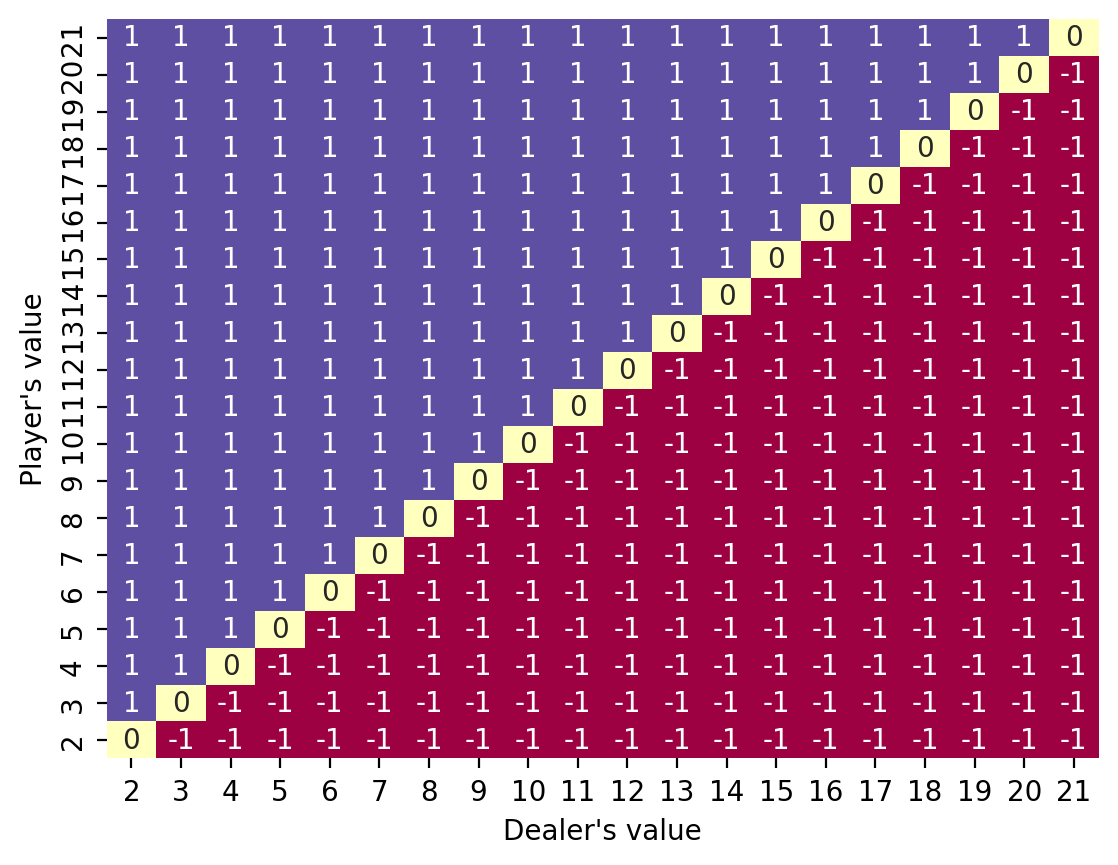

In [360]:
value_cards = np.arange(2, 22)

rewards_grid = np.array([[compute_reward(p, d) for d in value_cards] for p in value_cards])
rewards_grid = pd.DataFrame(rewards_grid, index=value_cards, columns=value_cards)
ax = sns.heatmap(rewards_grid, cmap="Spectral", annot=True, cbar=False)
ax.invert_yaxis()
plt.ylabel("Player's value")
plt.xlabel("Dealer's value");

The player makes a decision on the basis of three variables:
1. his current sum (12-21),
2. the dealer's one showing card (ace-10), and
3. whether or not he holds a usable ace

In [361]:
# Number of states
(21 - 12 + 1) * (10 - 1 + 1) * 2

200

In [362]:
PLAY_MINVAL = 2
PLAY_MAXVAL = 21

# We consider the policy that sticks if the player's sum is 20 or 21
# and sticks otherwise
policy = np.zeros((
    PLAY_MAXVAL - PLAY_MINVAL + 1, # Player's value
    2, # has usable ace
    PLAY_MAXVAL - PLAY_MINVAL + 1 # Dealer's value
), dtype=np.int32)
policy[:-2] = 1

policy.shape

(20, 2, 20)

In [363]:
state_init = (20, 1, 10)
play_single(*state_init, policy=policy)

(1, (20, 18))

In [364]:
state_init = init_game()
state_init

(13, False, 5)

### Analysing play-by-play

In [365]:
set_seed(31415)
state_init = (4, 0, 5)
reward, values, hist = play_single_hist(*state_init, policy=policy)

In [366]:
# states
hist[0][:-1]

[[4, 0, 5], [7, 0, 5], [15, 0, 5]]

In [367]:
# actions
hist[1]

[1, 1, 1]

In [368]:
# rewards
hist[2][1:]

[0, 0, -1]

In [369]:
values

(25, 19)

$$
    S_0, A_0, R_1, S_1, A_1, R_2, \ldots, S_{T-1}, A_{T-1}, R_T
$$

## Estimating the value function via first-visit MC

In [506]:
set_seed(31415)
state_init = init_game()
reward, values, hist = play_single_hist(*state_init, policy=policy)
discount = 1

In [507]:
hist_state, hist_action, hist_reward = hist

In [508]:
hist_state

[[11, 0, 10], [12, 1, 10], [15, 1, 10], [25, 1, 10]]

In [544]:
grid_rewards = np.zeros_like(policy)
grid_count = np.zeros_like(policy)

In [547]:
@njit
def single_first_visit_mc(grid_rewards, grid_count, policy):
    grid_rewards = grid_rewards.copy()
    grid_count = grid_count.copy()
    
    player_cards, ace, dealer_card = init_game()
    reward, values, hist = play_single_hist(player_cards, ace, dealer_card, policy=policy)
    hist_state, hist_action, hist_reward = hist
    T = len(hist_state)

    sim_reward = 0
    for t in range(-2, -(T + 1), -1):
        r = hist_reward[t + 1]
        sim_reward = discount * sim_reward + r

        current_state = hist_state[t]
        previous_states = hist_state[:t]

        first_visit = current_state not in previous_states
        if first_visit:    
            value_cards_player, has_usable_ace, dealers_card = current_state
            ixs = state_to_ix(value_cards_player, has_usable_ace, dealers_card)
            ix_value_cards, ix_has_usable_ace, ix_dealers_card = ixs

            grid_rewards[ix_value_cards, ix_has_usable_ace, ix_dealers_card] = sim_reward
            grid_count[ix_value_cards, ix_has_usable_ace, ix_dealers_card] += 1
    
    return grid_rewards, grid_count

In [548]:
single_first_visit_mc(grid_rewards, grid_count, policy)

(array([[[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]],
 
        [[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]],
 
        [[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]],
 
        [[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0]],
 
        [[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0],
         [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
     

## Old stuff

In [4]:
@njit
def update_player_card(current_value, new_card):
    """
    Update the player's hand value.
    
    Parameters
    ----------
    current_value: int
        Current value of player's hand
    new_card: int
        Randomly-drawn card
    
    Returns
    -------
    tuple: (int, bool)
        1. New value of player's hand
        2. Whether the there is a usable ace.
    """
    has_usable_ace = False
    if new_card == 1.0 and current_value <= 10:
        new_card = 11
        has_usable_ace = True
        
    new_value = current_value + new_card
    return new_value, has_usable_ace




@njit
def blackjack(player_value_cards, dealer_cards, policy, has_usable_ace):
    """
    Evaluate a single play of Blackjack.
    
    For some reason, a player can only have a minimum value of 12
    on her initial value cards.
    
    At the start of the game, we are given the initial value of the cards
    of the player, the initial dealer cards and a policy for the player.
    Furtheremore, we are given whether the player has a usable ace.
    
    Actions:
        0: hit
        1: stick
    

    Parameters
    ----------
    player_value_cards: float
        Current value cards for the players
    dealer_cards: jnp.array(2)
        Dealer's initial cards
    policy: jnp.array(G,A)
        2d-array specifying if having value g ∈ G the player
        should take action a ∈ A, i.e., policy[g,a] == 1.0
        if action a should be taken if the value of the cards
        is g.
    has_usable_ace: bool
        Wehether the initial player_value_cards contains a
        usable ace.
    """
    reward = 0
    
    hist_reward = [reward]
    hist_state = [(player_value_cards, has_usable_ace)]
    hist_action = [0]
    
    
    dealer_value_cards = np.sum(dealer_cards)
    
    # Stick if you have 21
    if player_value_cards == 21 and dealer_value_cards != 21:
        reward = 1
        
        hist_reward.append(reward)
        hist_state.append((player_value_cards, has_usable_ace))
        hist_action.append(1)
        
        return reward
    
    # Strickly speaking, the policy should depend on:
    #  1. The current state of the player, i.e., the value of her cards
    #  2. The only card we observe of the dealer
    # In this example, we consider a policy that only depends
    # on the current value of the player's cards.

    # Hit until you reach a 'stick' state or you lose (value of cards over 21)
    while policy[player_value_cards - 12][1] != 1.0:
        new_card = draw_card()
        player_value_cards, new_has_usable_ace = update_player_card(player_value_cards, new_card)
        has_usable_ace = has_usable_ace or new_has_usable_ace # keep usable ace if player already did have one.
        hist_reward.append(0)
        hist_action.append(0)
        hist_state.append((player_value_cards, has_usable_ace))
        
        if player_value_cards > 21:
            break
            
    dealer_value_cards = dealer_strategy(sum(dealer_cards))
    
    if player_value_cards > 21:
        reward = -1
    elif dealer_value_cards > 21:
        reward = 1
    else:
        reward = 1 if player_value_cards > dealer_value_cards else 0
    
    hist_reward.append(reward)
    
    return reward, hist_reward

In [6]:
# Value 10 corresponds to 10, Jack, Queen, and King.
n_vals = np.ones(10)
n_vals[-1] = 4
deck_probs = n_vals / n_vals.sum()

## References
1. https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter05/blackjack.py